In [9]:
# Import Statements 
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import sample, randint
from tqdm import tqdm_notebook as tqdm

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from keras.models import Model
from keras.utils import np_utils
from keras.models import Sequential
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import keras.backend as K

plt.style.use('seaborn-pastel')
plt.rcParams['figure.dpi'] = 100

In [10]:
# Function to display a graph for the distribution of classes in a dataset
def show_graph(categories, y, color = 'blue', title = "Dataset Distribution"):
    counts = [list(y).count(x) for x in set(y)]
    y_pos = np.arange(len(categories))
    plt.barh(y_pos, counts, color = color)
    plt.yticks(y_pos, categories, rotation="horizontal")
    plt.xlabel("Number of Samples")
    plt.ylabel("Categories")
    plt.title(title)
    plt.show()

# Function to loads the data, given a folder name
def load_data(path):
    data = load_files(path, load_content=False)
    filenames = data['filenames']
    target_names = data['target_names']
    target = data['target']
    # targets = np_utils.to_categorical(data['target'], 12)
    return filenames, target, target_names

# Data Exploration

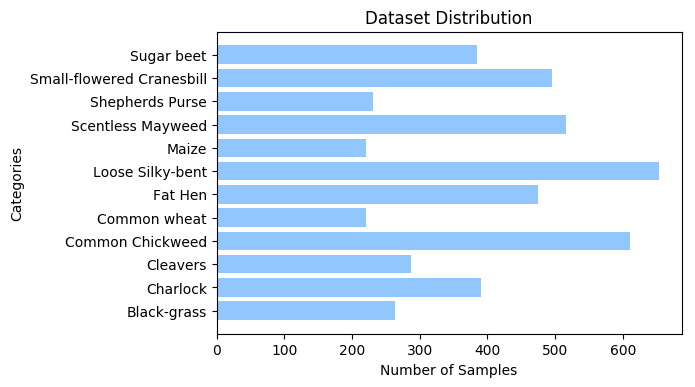

In [11]:
# Let us first load the data
X, y, classes = load_data("train")

# Check the distribution of the classes
show_graph(classes, y, None)

Black-grass


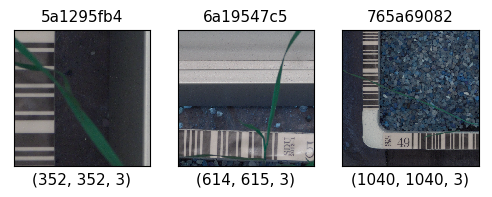

Charlock


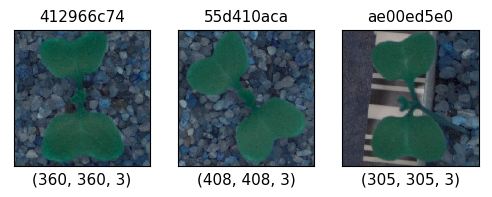

Cleavers


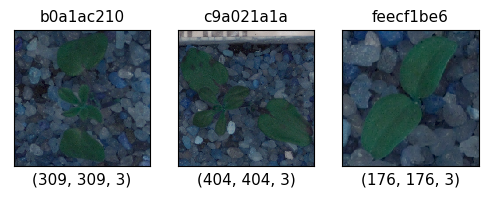

Common Chickweed


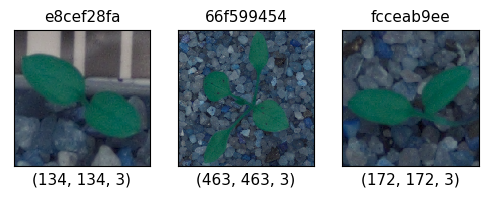

Common wheat


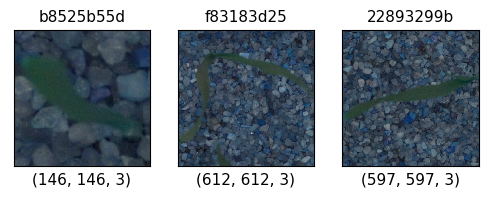

Fat Hen


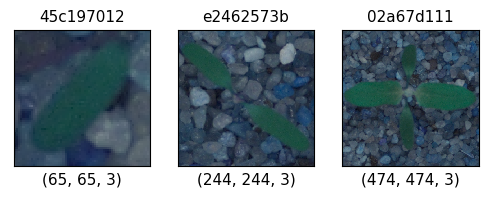

Loose Silky-bent


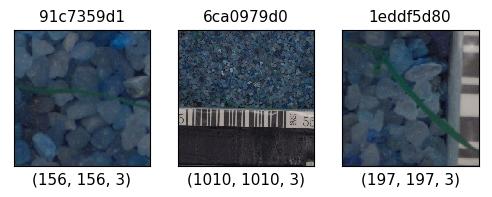

Maize


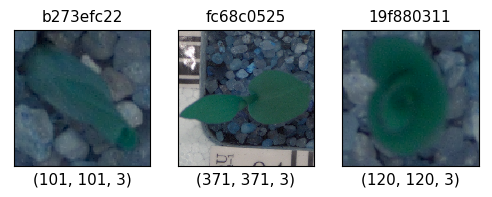

Scentless Mayweed


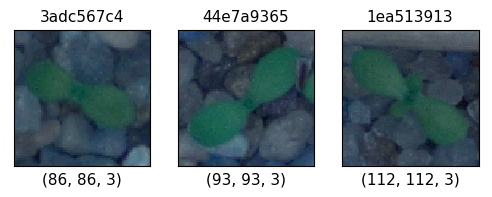

Shepherds Purse


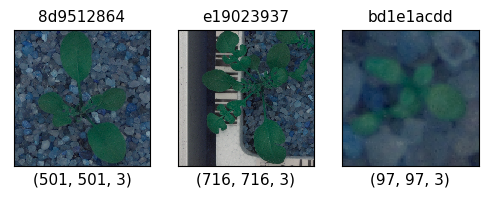

Small-flowered Cranesbill


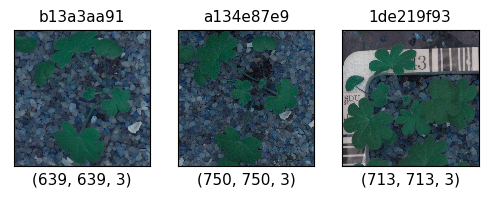

Sugar beet


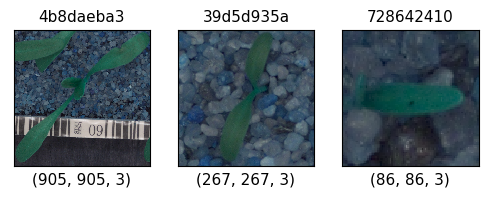

In [4]:
# Function to display random samples of a particular class
def show_samples(category, num_samples):
    fig = plt.figure()
    font = 14 - num_samples
    paths = [X[i] for i in range(len(X)) if y[i] == category]
    print(paths[0].split("/")[1])
    for i, path in enumerate(sample(list(paths), num_samples)):
        img = cv2.imread(path)
        fig.add_subplot(1, num_samples, i+1, xticks=[], yticks=[])
        plt.xlabel(img.shape, fontsize=font)
        plt.imshow(img)
        plt.title(path.split("/")[-1][:-4], fontsize=font)
    plt.show()

# Display 3 random samples of each class
for i in range(len(classes)):
    show_samples(i, num_samples=3)

In [12]:
# This function is used to load the image from the path into a tensor 
def path_to_tensor(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

# Function to prepare the data sets for use in a keras model
def prepare_data(X, y):
    X_data = [path_to_tensor(x) for x in tqdm(X)]
    y_data = np_utils.to_categorical(y, 12)
    return np.vstack(X_data).astype('float32')/255, y_data

# Data Preprocessing

In [57]:
# We will use the following functions developed by Gábor Vecsei, found here:
# https://www.kaggle.com/gaborvecsei/plant-seedlings-fun-with-computer-vision
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

def apply_transform(image):
    image_final = segment_plant(image)
    image_final = sharpen_image(image_final)
    return image_final

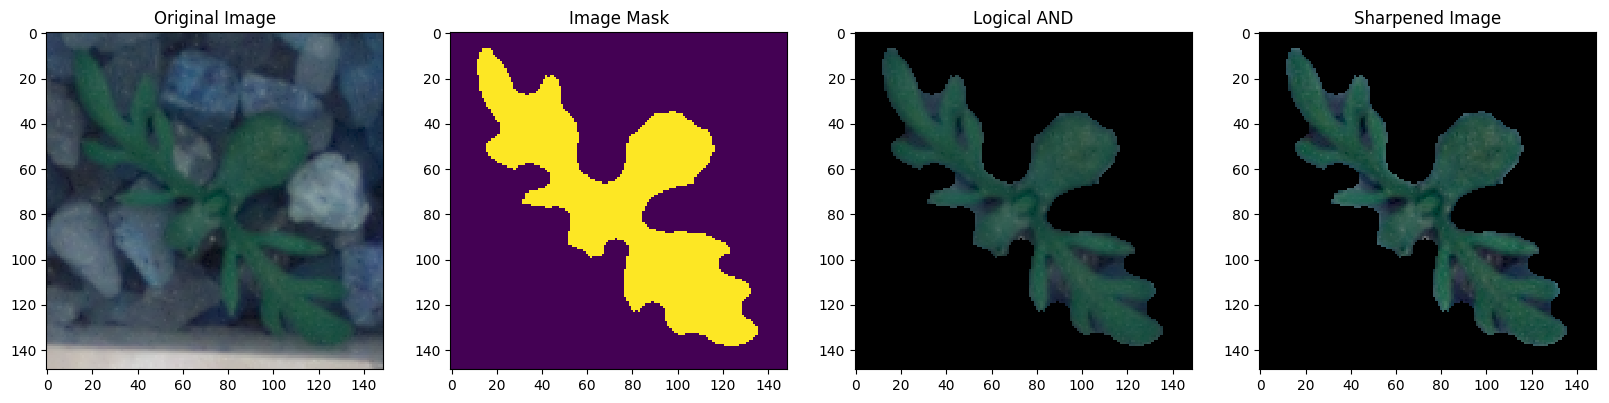

In [11]:
# THe code segment shows the result of the preprocessing at different stages
img = cv2.imread(X[randint(0, len(X))])
mask = create_mask_for_plant(img)
segments = segment_plant(img)
final = apply_transform(img)

fig, ax = plt.subplots(1, 4, figsize=(20, 20))
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[1].imshow(mask)
ax[1].set_title("Image Mask")
ax[2].imshow(segments)
ax[2].set_title("Logical AND")
ax[3].imshow(final)
ax[3].set_title("Sharpened Image")

plt.show()

In [58]:
# Convert all the images to pre-processed versions
for x in tqdm(X):
    img = cv2.imread(x)
    img = apply_transform(img)
    cv2.imwrite(x, img)

HBox(children=(IntProgress(value=0, max=4750), HTML(value='')))

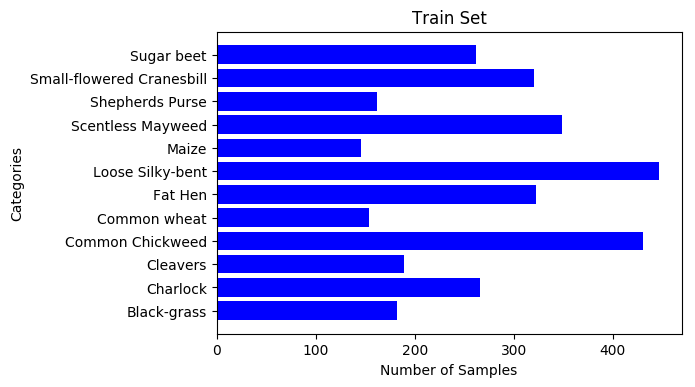

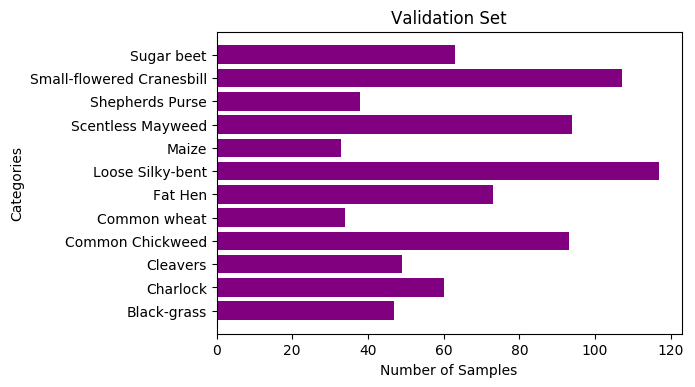

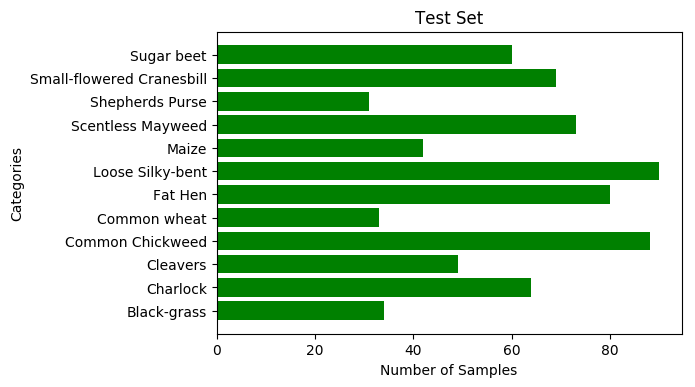

In [14]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Let us analyse the data distributions in the train, test and validation sets 
show_graph(classes, y_train, "blue", title = "Train Set")
show_graph(classes, y_val, "purple", title = "Validation Set")
show_graph(classes, y_test, "green", title = "Test Set")

In [15]:
# Load the data into the corresponding tensors
X_train, y_train = prepare_data(X_train, y_train)
X_test,  y_test = prepare_data(X_test,  y_test)
X_val, y_val = prepare_data(X_val, y_val)

print("Train set contains %d images" % (len(X_train)))
print("Validation set contains %d images" % (len(X_val)))
print("Test set contains %d images" % (len(X_test)))

HBox(children=(IntProgress(value=0, max=3229), HTML(value='')))

HBox(children=(IntProgress(value=0, max=713), HTML(value='')))

HBox(children=(IntProgress(value=0, max=808), HTML(value='')))


Train set contains 3229 images
Validation set contains 808 images
Test set contains 713 images


In [22]:
# Building benchmark models
# Benchmark Model 1: The Random Chance model:

def predict_random(images):
    return [sample(range(12), 1)[0] for _ in range(len(images))]

In [23]:
y_random = np.array(predict_random(X_test))
score = f1_score(y_test, np_utils.to_categorical(y_random), average='micro')
print("The first benchmark model achieved an F1 score of", score)

The first benchmark model achieved an F1 score of 0.0743338008415


In [24]:
# The following code has been borrowed from https://github.com/GeekLiB/keras/blob/master/keras/metrics.py

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

In [25]:
# Functions to converniently train and test different keras models.

def train_model(model, optimizer, epochs = 10, patience = 5, file = "from_scratch"):
    weights_path = 'weights.best.'+ file +'.hdf5'
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta_score])
    checkpointer = ModelCheckpoint(filepath= weights_path,
                                   verbose=1, save_best_only=True)
    stop = EarlyStopping(monitor='val_loss', min_delta=0.05, patience=5, verbose = 1)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=epochs, batch_size=16, callbacks=[checkpointer,  stop], verbose=1)
    return weights_path, history

def test_model(model, best_weights, X_test, y_test):
    model.load_weights(best_weights)
    y_pred = np.array([np.argmax(model.predict(np.expand_dims(x, axis=0))) for x in X_test])
    y_true = np.argmax(y_test, axis = 1 )
    cm = confusion_matrix(y_true, y_pred)
    score = f1_score(y_true, y_pred, average = 'micro')
    return score, cm


In [13]:
# Benchmark Model 2: A Simple Neural Network build from scratch
model = Sequential()

model.add(Conv2D(16, kernel_size = 3, input_shape = (224,224,3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(GlobalAveragePooling2D())
model.add(Dense(12, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       73856     
__________

In [14]:
# Train and Test the benchmark model
best_weights, history = train_model(model, "adam", epochs = 50)

score, cm = test_model(model, best_weights, X_test, y_test)

Train on 3229 samples, validate on 808 samples
Epoch 1/50
3229/3229 [==============================] - 12s - loss: 2.0441 - fbeta_score: 0.0835 - val_loss: 1.7759 - val_fbeta_score: 0.1539
Epoch 2/50
3229/3229 [==============================] - 11s - loss: 1.6478 - fbeta_score: 0.2425 - val_loss: 1.5117 - val_fbeta_score: 0.3134
Epoch 3/50
3229/3229 [==============================] - 11s - loss: 1.4895 - fbeta_score: 0.3126 - val_loss: 1.5896 - val_fbeta_score: 0.3266
Epoch 4/50
3229/3229 [==============================] - 11s - loss: 1.3577 - fbeta_score: 0.3820 - val_loss: 1.4737 - val_fbeta_score: 0.3597
Epoch 5/50
3229/3229 [==============================] - 11s - loss: 1.2838 - fbeta_score: 0.4391 - val_loss: 1.3675 - val_fbeta_score: 0.3978
Epoch 6/50
3229/3229 [==============================] - 11s - loss: 1.2340 - fbeta_score: 0.4773 - val_loss: 1.2960 - val_fbeta_score: 0.4927
Epoch 7/50
3229/3229 [==============================] - 11s - loss: 1.1291 - fbeta_score: 0.5437 - va

In [15]:
print("The second benchmark model achieved an F1 score of", score)

The second benchmark model achieved an F1 score of 0.856942496494


In [26]:
# Let us now build a model using Transfer Learning 

base_model = Xception(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in base_model.layers[:100]:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(12, activation='softmax')(x)
model_X = Model(base_model.input, predictions)
model_X.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 111, 111, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 111, 111, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 111, 111, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [27]:
# Train and test the superior model
best_weights, history = train_model(model_X, "adam", 10, file = "Xception")

score, cm = test_model(model_X, best_weights, X_test, y_test)

Train on 3229 samples, validate on 808 samples
Epoch 1/10
3229/3229 [==============================] - 64s - loss: 0.7067 - fbeta_score: 0.7456 - val_loss: 0.7644 - val_fbeta_score: 0.7762
Epoch 2/10
3229/3229 [==============================] - 62s - loss: 0.3348 - fbeta_score: 0.8857 - val_loss: 0.4804 - val_fbeta_score: 0.8585
Epoch 3/10
3229/3229 [==============================] - 62s - loss: 0.2588 - fbeta_score: 0.9090 - val_loss: 0.2837 - val_fbeta_score: 0.9100
Epoch 4/10
3229/3229 [==============================] - 62s - loss: 0.1789 - fbeta_score: 0.9376 - val_loss: 0.2557 - val_fbeta_score: 0.9148
Epoch 5/10
3229/3229 [==============================] - 62s - loss: 0.1356 - fbeta_score: 0.9537 - val_loss: 0.3943 - val_fbeta_score: 0.9039
Epoch 6/10
3229/3229 [==============================] - 62s - loss: 0.1385 - fbeta_score: 0.9511 - val_loss: 0.5443 - val_fbeta_score: 0.8677
Epoch 7/10
3229/3229 [==============================] - 62s - loss: 0.1029 - fbeta_score: 0.9642 - va

In [29]:
print("The Transfer Learning model achieved an F1 score of", score)

The Transfer Learning model achieved an F1 score of 0.915848527349


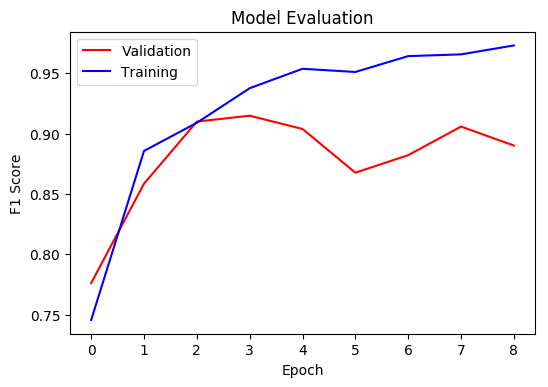

In [54]:
# Compare the training and validation F1 scores 
fig, ax = plt.subplots(1)
plt.plot(history.history["val_fbeta_score"], color = "red", label = "Validation")
plt.plot(history.history["fbeta_score"], color = "blue", label = "Training")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Model Evaluation")
ax.legend()
plt.show()

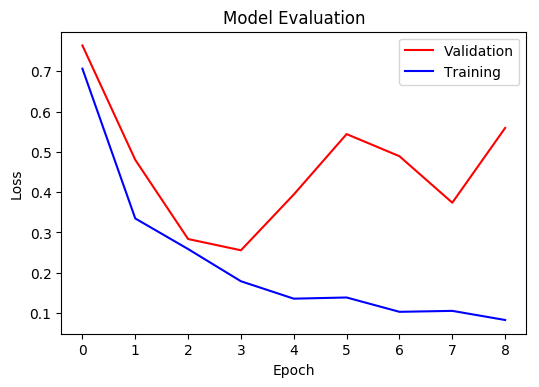

In [56]:
# Compare the training and validation Losses
fig, ax = plt.subplots(1)
plt.plot(history.history["val_loss"], color = "red", label = "Validation")
plt.plot(history.history["loss"], color = "blue", label = "Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Evaluation")
ax.legend()
plt.show()

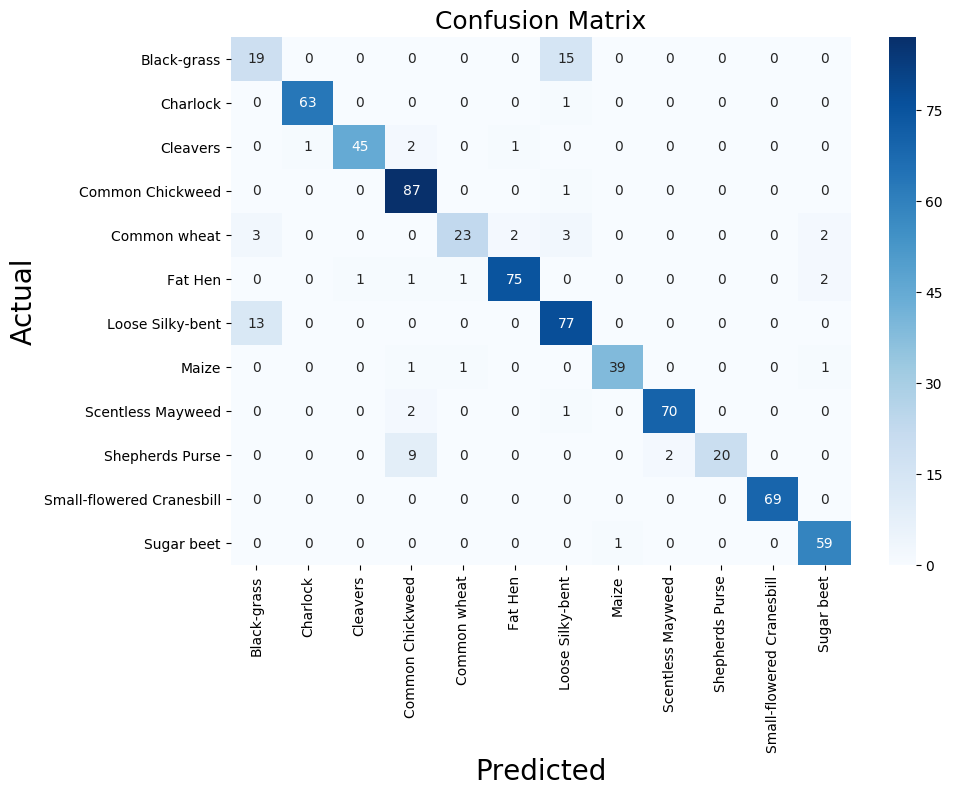

In [61]:
# Display a heatmap representing the Confusion Matrix of the final model. 
fig, ax = plt.subplots(figsize= (10,7))
title = "Confusion Matrix"
plt.title(title, fontsize = 18)
ttl = ax.title
sns.heatmap(cm, annot = True, cmap = "Blues", xticklabels = classes, yticklabels= classes )
ttl.set_position([0.5, 1,.05])
ax.set_xlabel("Predicted", fontsize = 20)
ax.set_ylabel("Actual", fontsize = 20)
plt.show()